In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy
from scipy import signal
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
%matplotlib inline

# Purpose

This notebook was established for building the methods for the three operator approach and testing if these methods agreed with each other. The functions were written for each step of the method ($L_1$, $L_2$, and $L_3$) since we need to pick an implementation of all three steps in order to time evolve our intial state. These functions then can be combined, since they all have the same output, in a single method for simulation.

# Initializing Problem

In [2]:
dim = 81

nx = np.linspace(-4,4,dim)
ny = np.linspace(-4,4,dim)

# nx = np.linspace(-4-np.diff(nx)[0],4+np.diff(nx)[0],dim+2)
# ny = np.linspace(-4-np.diff(ny)[0],4+np.diff(ny)[0],dim+2)

X, Y = np.meshgrid(nx,ny)

#Functions
K=1
gamma = 2.1
sigma = 0.8
delta_s = np.pi/1000

a_1 = lambda x,y: K*x
a_2 = lambda x,y: gamma*y
a_3 = lambda x,y: 0
a_4 = lambda x,y: sigma

delta_x = np.diff(X,axis=1).max()
delta_y = np.diff(Y,axis=0).max()

g = lambda x,y: a_1(x,y)+a_2(x,y)

We are going to try this again, but here we are going to split the operator into three parts similar to the work in _:

In [3]:
#################################################################################################################

def explicit_L3(U,delta_x, delta_t,kappa=.8):
    """
    Will represent an second derivative operator (L3) that will take the solution forward one time step with
    a diffusion constant D, delta_x, and delta_t implemented with an explicit scheme with boundary conditions
    set to zero.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *kappa* (float) Diffusion Constant
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    """
    x2_dim= U.shape[0]
    r = (kappa* delta_t / (2*delta_x**2))
    d = numpy.ones(x2_dim)
    
    A = numpy.diag((1-2*r)*d) + numpy.diag(r*d[1:],1)+ numpy.diag(r*d[1:],-1)
    
    for i in range(x2_dim):
        U[:,i] = numpy.dot(A,U[:,i])

    return U

def solve_CN(U,delta_x, delta_t,kappa=.8):
    """Will represent an second derivative operator (L3) that will take the solution forward one time step with
    a diffusion constant D, delta_x, and delta_t implemented with a Crank-Nicholson Scheme with boundary conditions
    set to zero.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *kappa* (float) Diffusion Constant
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    """
    x2_dim= U.shape[0]
    r = (kappa* delta_t / (2*(delta_x**2)))
    d = numpy.ones(x2_dim)
    
    A = numpy.diag((1+2*r)*d) + numpy.diag(-r*d[1:],1)+ numpy.diag(-r*d[1:],-1)
    B = numpy.diag((1-2*r)*d) + numpy.diag(r*d[1:],1)+ numpy.diag(r*d[1:],-1)
    
    for i in range(x2_dim):
        f = numpy.dot(B,U[:,i])
        U[:,i] = numpy.linalg.solve(A,f)

    return U

def solve_BE(U,delta_x, delta_t,kappa=.8):
    """Will represent an second derivative operator (L3) that will take the solution forward one time step with
    a diffusion constant D, delta_x, and delta_t implemented with a Backwards-Euler Scheme with boundary conditions
    set to zero.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *kappa* (float) Diffusion Constant
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    
    """
    
    x2_dim= U.shape[0] 
    
    r = (kappa* delta_t / (delta_x**2))
    d = numpy.ones(x2_dim)
    A = numpy.diag((1+2*r)*d) + numpy.diag(-r*d[1:],1)+ numpy.diag(-r*d[1:],-1)
    
    for i in range(x2_dim):
        U[:,i] = numpy.linalg.solve(A,U[:,i])
#         U[i+1,0] = U[i,0] + kappa*delta_t/delta_x**2 * (g_0 - 2.0*U[i,0]+U[i,1])
#         U[i+1,-1] = U[i,-1] + kappa*delta_t/delta_x**2 * (U[i,-2] - 2.0*U[i,-1]+g_1)
        
    return U

def solve_BE_mod(U,delta_x,delta_t,kappa=.8):
    """Will represent an second derivative operator (L3) that will take the solution forward one time step with
    a diffusion constant D, delta_x, and delta_t implemented with a Backwards-Euler Scheme with boundary conditions
    set to zero. This one also uses a Scipy based implementation.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *kappa* (float) Diffusion Constant
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    
    """
    x2_dim= U.shape[0] 
    
    r = (kappa* delta_t / (delta_x**2))
    e = numpy.ones(x2_dim)*r
    D2 = sparse.spdiags([e,-2.0*e,e],[-1,0,1],x2_dim,x2_dim).tocsr()
    I = sparse.eye(x2_dim).tocsr()
    A1 = (I-D2)
    
    for i in range(x2_dim):
        U[:,i] = linalg.spsolve(A1,U[:,i])
#         U[i+1,0] = U[i,0] + kappa*delta_t/delta_x**2 * (g_0 - 2.0*U[i,0]+U[i,1])
#         U[i+1,-1] = U[i,-1] + kappa*delta_t/delta_x**2 * (U[i,-2] - 2.0*U[i,-1]+g_1)
        
    return U

def solve_CN_mod(U,delta_x,delta_t,kappa=.8):
    """Will represent an second derivative operator (L3) that will take the solution forward one time step with
    a diffusion constant D, delta_x, and delta_t implemented with a Crank-Nicholson Scheme with boundary conditions
    set to zero. This one also uses a scipy based implementation.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *kappa* (float) Diffusion Constant
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    """
    x2_dim= U.shape[0] 
    
    r = (0.5*kappa* delta_t / (delta_x**2))
    e = numpy.ones(x2_dim)*r
    D2 = sparse.spdiags([e,-2.0*e,e],[-1,0,1],x2_dim,x2_dim).tocsr()
    I = sparse.eye(x2_dim).tocsr()
    A1 = (I-D2)
    A2 = (I+D2).tolil()
    
    for i in range(x2_dim):
        f = A2.dot(U[:,i].copy())
        U[:,i] = linalg.spsolve(A1,f)
#         U[i+1,0] = U[i,0] + kappa*delta_t/delta_x**2 * (g_0 - 2.0*U[i,0]+U[i,1])
#         U[i+1,-1] = U[i,-1] + kappa*delta_t/delta_x**2 * (U[i,-2] - 2.0*U[i,-1]+g_1)
        
    return U
################################################################################################################

In [4]:
def implicit_L1(U,delta_x,delta_t,Y=None):
    """Will represent a first derivative operator (L1) that will take the solution forward one time step with
    a delta_x, and delta_t with an implicit implementation.

    :Input:
    - *U* (numpy.ndarray) Input array
    - *delta_x* (float) Distance between points in discretization
    - *delta_t* (float) Length of a Time Step
    - *Y* (numpy.ndarray) Represents the underlying x2 variable which is involved in the process

    :Output:
    - (numpy.ndarray) Solution at one time step forward.
    """
    x2_dim= U.shape[1] 
    for i in range(x2_dim):
        temp=Y[i].copy()
        diag = (delta_t*temp[:-1])/(2*delta_x)
        B = np.eye(x2_dim)+np.diag(diag,1)-np.diag(diag,-1)

        U[i]=np.linalg.solve(B,U[i])

    return U

def explicit_L1(U,delta_x,delta_t,Y=None):
    """Will represent a first derivative operator (L1) that will take the solution forward one time step with
    a delta_x, and delta_t with an explicit implementation.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *Y* (numpy.ndarray) Represents the underlying x2 variable which is involved in the process
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    """
    
    x2_dim= U.shape[1] 
    for i in range(x2_dim):
        diag = (delta_t*Y[i].copy())/(2*delta_x)
        temp = np.pad(U[i].copy(),(1,1),'constant')
        U[i]-=diag*(temp[2:]-temp[:-2])
        
    return U

def implicit_L2(U,delta_x,delta_t,X=None,Y=None,g=None):
    """Will represent a first derivative operator (L2) that will take the solution forward one time step with
    a delta_x, and delta_t with an implicit implementation.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *X* (numpy.ndarray) Represents the underlying x1 variable which is involved in the process
     - *Y* (numpy.ndarray) Represents the underlying x2 variable which is involved in the process
     - *g* (function) Represents a function on x1 and x2 that is involved with the L2 term
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    """
    x1_dim= U.shape[0] 
    for i in range(x1_dim):
        top_diag = ((delta_t*g(X[:,i],Y[:,i]))/(2*delta_x))[1:]
        bot_diag = ((delta_t*g(X[:,i],Y[:,i]))/(2*delta_x))[:-1]
        B = np.eye(x1_dim)-np.diag(top_diag,1)+np.diag(bot_diag,-1)
        B[0,1]=0
        B[-1,-2]=0
        U[:,i]=np.linalg.solve(B,U[:,i])
        
    return U


def explicit_L2(U,delta_x,delta_t,X=None,Y=None,g=None):
    """Will represent a first derivative operator (L2) that will take the solution forward one time step with
    a delta_x, and delta_t with an explicit implementation.
    
    :Input:
     - *U* (numpy.ndarray) Input array
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *X* (numpy.ndarray) Represents the underlying x1 variable which is involved in the process
     - *Y* (numpy.ndarray) Represents the underlying x2 variable which is involved in the process
     - *g* (function) Represents a function on x1 and x2 that is involved with the L2 term
     
    :Output:
     - (numpy.ndarray) Solution at one time step forward.
    """
    x1_dim= U.shape[0] 
    for i in range(x1_dim):
        temp = np.pad(U[:,i].copy(),(1,1),'constant')
        diag = ((delta_t*g(X[:,i],Y[:,i]))/(2*delta_x))
        U[:,i]+=diag*(temp[2:]-temp[:-2])
        
    return U

# Testing L3

Here we are testing the diffusion of a Gaussian with Backwards Euler

In [5]:
check3BE = np.outer(signal.gaussian(81,4),signal.gaussian(81,4))
checks3BE=[]
for i in range(100):
    check3BE=solve_BE_mod(check3BE,0.1,np.pi/1000,kappa=0.8)
    checks3BE.append(check3BE.copy())

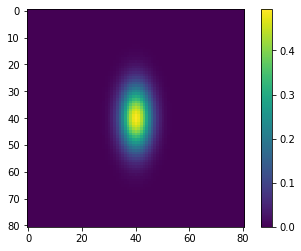

In [6]:
plt.imshow(check3BE);plt.colorbar()

Here we are testing the diffusion of a Gaussian with Crank-Nicholson

In [7]:
check3CN = np.outer(signal.gaussian(81,4),signal.gaussian(81,4))
checks3CN=[]
for i in range(100):
    check3CN=solve_CN_mod(check3CN,0.1,np.pi/1000,kappa=0.8)
    checks3CN.append(check3CN.copy())

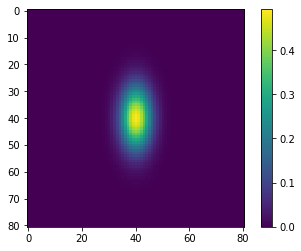

In [8]:
plt.imshow(check3CN);plt.colorbar()

Here we are testing the diffusion of a Gaussian with an Explicit Approach

In [9]:
check3E = np.outer(signal.gaussian(81,4),signal.gaussian(81,4))
checks3E=[]
for i in range(100):
    check3E=explicit_L3(check3E,0.1,np.pi/1000,kappa=0.8)
    checks3E.append(check3E.copy())

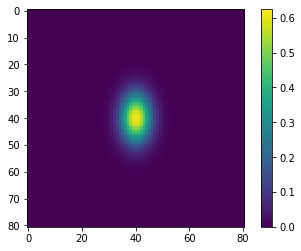

In [10]:
plt.imshow(check3E);plt.colorbar()

# Testing L2

### Explicit Test

In [11]:
check2 = np.outer(signal.gaussian(81,4),signal.gaussian(81,4))
checks=[]
for i in range(100):
    check2=implicit_L2(check2,0.1,np.pi/500,X=X,Y=Y,g=g)
#     check2=implicit_L2(check2,0.1,np.pi/500,X=X,Y=Y,g=g)
    checks.append(check2.copy())

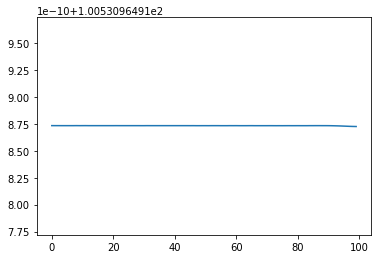

In [12]:
# We ensure that the is no probability leakage or strange effects due to boundary conditions
plt.plot([np.sum(c) for c in checks])

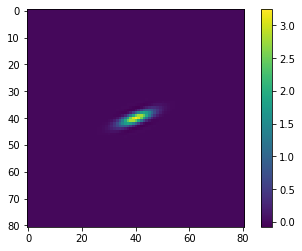

In [13]:
plt.imshow(check2);plt.colorbar()

### Implicit Test

In [14]:
check22 = np.outer(signal.gaussian(81,4),signal.gaussian(81,4))
checks = []
for i in range(100):
    check22=explicit_L2(check22,0.1,np.pi/500,X=X,Y=Y,g=g)
    checks.append(check22.copy())

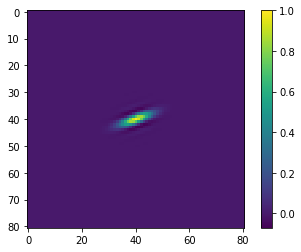

In [15]:
plt.imshow(check22);plt.colorbar()

# Testing L1

In [16]:
check = np.outer(signal.gaussian(81,4),signal.gaussian(81,4))
checks=[]
for i in range(100):
    check=implicit_L1(check,0.1,np.pi/500,Y=Y)
    checks.append(check.copy())

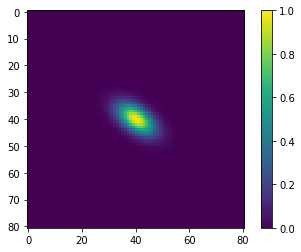

In [17]:
plt.imshow(check);plt.colorbar()

In [18]:
check1 = np.outer(signal.gaussian(81,4),signal.gaussian(81,4))
checks=[]
for i in range(100):
    check1=explicit_L1(check1,0.1,np.pi/500,Y=Y)
    checks.append(check1)

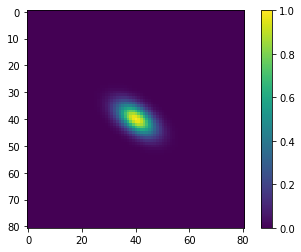

In [19]:
plt.imshow(check1);plt.colorbar()

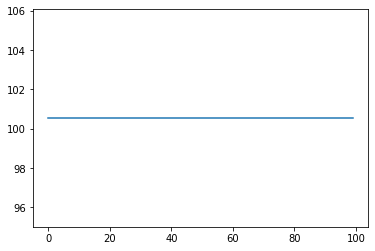

In [20]:
plt.plot([np.sum(c) for c in checks])

# Test Code

In [21]:
def run_test(delta_x, delta_t, time_steps, initial_condition, L1=None, L2 = None, L3=None, X=X, Y=Y, g=g, kappa=.8,t_0=0):
    """
    Code meant to combine L1, L2, and L3 steps in order to simulate the Fokker Planck Equations
    
    :Input:
     - *delta_x* (float) Distance between points in discretization
     - *delta_t* (float) Length of a Time Step
     - *time_steps* (int) Number of time steps
     - *initial_condition* (numpy.ndarray) initial condition
     - *L1* (function) function that represents the L1 operator
     - *L2* (function) function that represents the L2 operator
     - *L2* (function) function that represents the L3 operator
     - *X* (numpy.ndarray) Represents the underlying x1 variable which is involved in the process
     - *Y* (numpy.ndarray) Represents the underlying x2 variable which is involved in the process
     - *g* (function) Represents a function on x1 and x2 that is involved with the L2 term
     - *kappa* (float) Term that controls the diffusion in the L3 operator
     - *t_0* starting time
     
    :Output:
     - *U* (numpy.ndarray) Solution
    """
    
    print("Beginning Test")
    U=initial_condition.copy()
    errors=[]
    
    dim1, dim2 = X.shape
    t=t_0
    
    for i in range(time_steps):
        t+=delta_t
        U = L1(U,delta_x,delta_t,Y=Y)
        U = L2(U,delta_x,delta_t,X=X,Y=Y,g=g)
        U = L3(U,delta_x,delta_t,kappa=kappa)
        if i%100==0:
            print("@ Timestep {}".format(i))
            
        error=np.sqrt(np.sum((U-rho(X,Y,t))*(U-rho(X,Y,t)))/(dim1*dim2))
        errors.append(error)
    
    return U,errors

# Testing if the methods work with an exact solution

In [22]:
# Setting up the exact solution
mu_1 = -gamma/2+np.sqrt(gamma*gamma/4-K)
mu_2 = -gamma/2-np.sqrt(gamma*gamma/4-K)

xi = lambda x,v,t: (x*mu_1-v)*np.exp(-mu_2*t)
nu = lambda x,v,t: (x*mu_2-v)*np.exp(-mu_1*t)

a = lambda t: (sigma/mu_1)*(1-np.exp(-2*mu_1*t))
b = lambda t: (sigma/mu_2)*(1-np.exp(-2*mu_2*t))
h = lambda t: (-2*sigma/(mu_1+mu_2))*(1-np.exp(-(mu_1+mu_2)*t))
delta = lambda t: a(t)*b(t)-h(t)*h(t)

y_0=0
x_0=0

top = lambda x,y,t: (a(t)*(xi(x,y,t)-xi(x_0,y_0,0))**2+2*h(t)*(xi(x,y,t)-xi(x_0,y_0,0))*(nu(x,y,t)-nu(x_0,y_0,0))+b(t)*(nu(x,y,t)-nu(x_0,y_0,0))**2)/(2*delta(t))
rho = lambda x,y,t: np.exp(gamma*t)*np.exp(-top(x,y,t))/(2*np.pi*np.sqrt(delta(t)))

In [23]:
test=rho(X,Y,0.95)

In [24]:
run=test.copy()
runs = 800

for i in range(runs):
    
    run = solve_CN(run,0.1,np.pi/1000,kappa=.8)
    run = implicit_L2(run,0.1,np.pi/1000,X=X,Y=Y,g=g)
    run = explicit_L1(run,0.1,np.pi/1000,Y=Y)

In [25]:
run=test.copy()
runs = 800

for i in range(runs):
    
    run = solve_CN(run,0.1,np.pi/1000,kappa=.8)
    run = explicit_L1(run,0.1,np.pi/1000,Y=Y)
    run = implicit_L2(run,0.1,np.pi/1000,X=X,Y=Y,g=g)

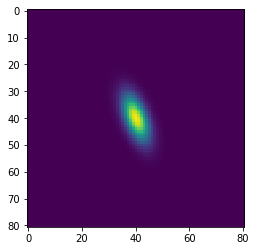

In [26]:
plt.imshow(test)

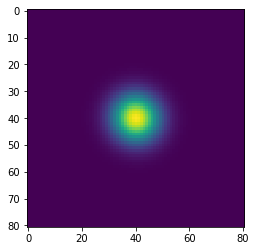

In [27]:
plt.imshow(run)

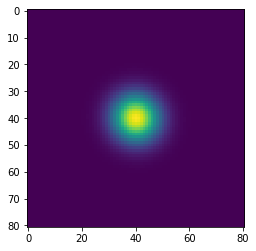

In [28]:
plt.imshow(rho(X,Y,0.95+runs*np.pi/1000))

In [29]:
np.sum(run)

156.17376344047386

In [30]:
np.sum(rho(X,Y,0.95+np.pi/10))

156.17376188825992

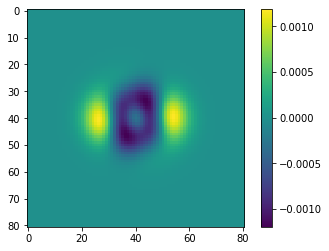

In [31]:
#Differences in a simulated solution and an exact solution
plt.imshow(run-rho(X,Y,0.95+runs*(np.pi/1000)));plt.colorbar()

In [32]:
#Error between the methods
np.sqrt(np.sum((run-rho(X,Y,0.95+runs*(np.pi/1000)))*(run-rho(X,Y,0.95+runs*(np.pi/1000))))/(81*81))

0.0002565995648198893

In [33]:
sol = run_test(0.1,np.pi/1000,800,rho(X,Y,0.95),L1 =explicit_L1,L2=implicit_L2,L3=solve_CN,t_0=0.95)

Beginning Test
@ Timestep 0
@ Timestep 100
@ Timestep 200
@ Timestep 300
@ Timestep 400
@ Timestep 500
@ Timestep 600
@ Timestep 700


In [34]:
sol[1][-1] #Final error of the method

0.0005764394741888423